In [1]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as pnp

from scipy.optimize import minimize

# General imports
import os
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp

# custom module
from susy_qm import calculate_Hamiltonian, create_vqd_plots

In [2]:
#potential = 'QHO'
potential = 'AHO'
#potential = 'DW'
cut_off = 16

In [3]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cut_off, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])
min_eigenvalue = min(eigenvalues.real)

#create qiskit Hamiltonian Pauli string
hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [4]:
num_qubits

5

In [5]:
#Initial params shape
num_layers = 1
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)

In [6]:
def ansatz(params, wires):
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
    qml.StronglyEntanglingLayers(weights=params, wires=wires, imprimitive=qml.CZ)

In [7]:
# Device
shots = 1024
dev = qml.device('lightning.qubit', wires=2*num_qubits+1, shots=shots)

@qml.qnode(dev)
def swap_test(params1, params2):

    params1 = pnp.tensor(params1.reshape(params_shape), requires_grad=True)
    params2 = pnp.tensor(params2.reshape(params_shape), requires_grad=True)

    ancilla = 2*num_qubits
    qml.Hadamard(wires=ancilla)

    ansatz(params1, wires=range(num_qubits))
    ansatz(params2, wires=range(num_qubits, 2*num_qubits))

    qml.Barrier()
    for i in range(num_qubits):
        qml.CSWAP(wires=[ancilla, i, num_qubits + i])

    qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)

In [8]:
# Example parameters for testing the swap test
params1 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))
params2 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))

# Run the swap test to get the probability of the ancilla being |0>
result = swap_test(params1, params2)

# The overlap is given by 2 * P(ancilla=0) - 1
#overlap = 2 * result[0] - 1
overlap = 1 - 2*result[1]

print(qml.draw(swap_test)(params1,params2))
print(f"\nOverlap between the ground state and the ansatz: {overlap}")

 0: ──Rot(0.54,3.14,1.44)─╭●──────────╭Z──||─╭SWAP────────────────────────────┤       
 1: ──Rot(4.81,4.21,2.32)─╰Z─╭●───────│───||─│─────╭SWAP──────────────────────┤       
 2: ──Rot(1.24,4.51,3.94)────╰Z─╭●────│───||─│─────│─────╭SWAP────────────────┤       
 3: ──Rot(3.01,6.21,0.80)───────╰Z─╭●─│───||─│─────│─────│─────╭SWAP──────────┤       
 4: ──Rot(3.47,0.14,4.80)──────────╰Z─╰●──||─│─────│─────│─────│─────╭SWAP────┤       
 5: ──Rot(6.12,4.46,3.32)─╭●──────────╭Z──||─├SWAP─│─────│─────│─────│────────┤       
 6: ──Rot(3.64,5.02,0.06)─╰Z─╭●───────│───||─│─────├SWAP─│─────│─────│────────┤       
 7: ──Rot(6.15,1.76,1.31)────╰Z─╭●────│───||─│─────│─────├SWAP─│─────│────────┤       
 8: ──Rot(5.57,6.02,4.88)───────╰Z─╭●─│───||─│─────│─────│─────├SWAP─│────────┤       
 9: ──Rot(2.06,1.88,1.57)──────────╰Z─╰●──||─│─────│─────│─────│─────├SWAP────┤       
10: ──H───────────────────────────────────||─╰●────╰●────╰●────╰●────╰●─────H─┤  Probs

Overlap between the ground state and the a

In [9]:
# Device
shots = 1024
dev2 = qml.device('lightning.qubit', wires=num_qubits, shots=shots)

@qml.qnode(dev2)
def expected_value(params):
    wires = range(num_qubits)
    ansatz(params, wires)
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))


def loss_f(params):
    global prev_param_list, beta
    energy = expected_value(params)

    penalty = 0

    if len(prev_param_list) != 0:
        for prev_param in prev_param_list:
            overlap =  1 - (2*swap_test(prev_param, params)[1])
            penalty += (beta*overlap)

    return energy + (penalty)

In [10]:
def callback(xk):
    global iteration_counter, counts, values
    
    current_cost = loss_f(xk)

    iteration_counter += 1
    counts.append(iteration_counter) 
    values.append(current_cost)

In [12]:
vqd_start = datetime.now()

#variables
num_vqd_runs = 4
max_iterations = 10000
beta = 2.0
tolerance = 1e-8

#data arrays
energies = []
prev_param_list = []
num_iters = []
run_times = []
success = []
run_times = []

all_counts = []
all_values = []
all_overlaps = []

#Initial params
scale = 0.25
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=num_qubits)
params = scale*np.pi * pnp.random.random(size=np.prod(params_shape))

for i in range(num_vqd_runs):

    run_start = datetime.now()

    iteration_counter = 0
    counts = []
    values = []    

    if i % 1 == 0:
        print(f"Run: {i}")


    res = minimize(loss_f,
                   x0=params,
                   method='COBYLA',
                   options={'maxiter': max_iterations, 'tol':tolerance},
                   callback=callback)
    
    all_counts.append(counts)
    all_values.append(values)        


    energies.append(res.fun)
    prev_param_list.append(res.x) 
    num_iters.append(res.nfev)
    success.append(res.success)

    run_end = datetime.now()
    run_time = run_end - run_start
    run_times.append(run_time)

    print(energies)

    # Calculate overlap with all previous states
    overlaps = []
    if i > 0:
        for j in range(i):
            overlap =  1 - (2*swap_test(prev_param_list[j], res.x)[1])
            overlaps.append(overlap)
        all_overlaps.append(overlaps)
        print(f"Overlaps with all previous states for run {i}: {overlaps}")

vqd_end = datetime.now()
vqd_time = vqd_end - vqd_start


Run: 0
[8.108854392464671]
Run: 1
[8.108854392464671, 10.81052325156227]
Overlaps with all previous states for run 1: [0.845703125]
Run: 2
[8.108854392464671, 10.81052325156227, 19.96140988611149]
Overlaps with all previous states for run 2: [0.32421875, 0.48046875]
Run: 3
[8.108854392464671, 10.81052325156227, 19.96140988611149, 20.36615226567517]
Overlaps with all previous states for run 3: [0.8984375, 0.9140625, 0.576171875]


In [45]:
#Save run
run = {
    'potential': potential,
    'cutoff': cut_off,
    'exact_eigenvalues': [round(x.real,10).tolist() for x in eigenvalues],
    'ansatz': 'StronglyEntanglingLayers-1layer',
    'num_VQD': num_vqd_runs,
    'Optimizer': {'name': 'COBYLA',
                'maxiter':max_iterations,
                'tolerance': tolerance
                },
    'converged_energies': energies,
    'converged_params': [x.tolist() for x in prev_param_list],
    'energies': all_values,
    'num_iters': all_counts,
    'success': np.array(success, dtype=bool).tolist(),
    'run_times': [str(x) for x in run_times],
    'total_run_time': str(vqd_time)
}

# Save the variable to a JSON file

starttime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder = str(starttime)
#Create directory for files
#base_path = r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\PennyLane\VQD\COBYLA\Files\{}\\{}\\".format(potential, folder)
base_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\SUSY\PennyLane\VQD\COBYLA\Files\{}\\{}\\".format(potential, folder)
os.makedirs(base_path)

path = base_path + "{}_{}.json".format(potential, cut_off)
with open(path, 'w') as json_file:
    json.dump(run, json_file, indent=4)

In [46]:
file_path = path
with open(file_path, 'r') as json_file:
    data = json.load(json_file)

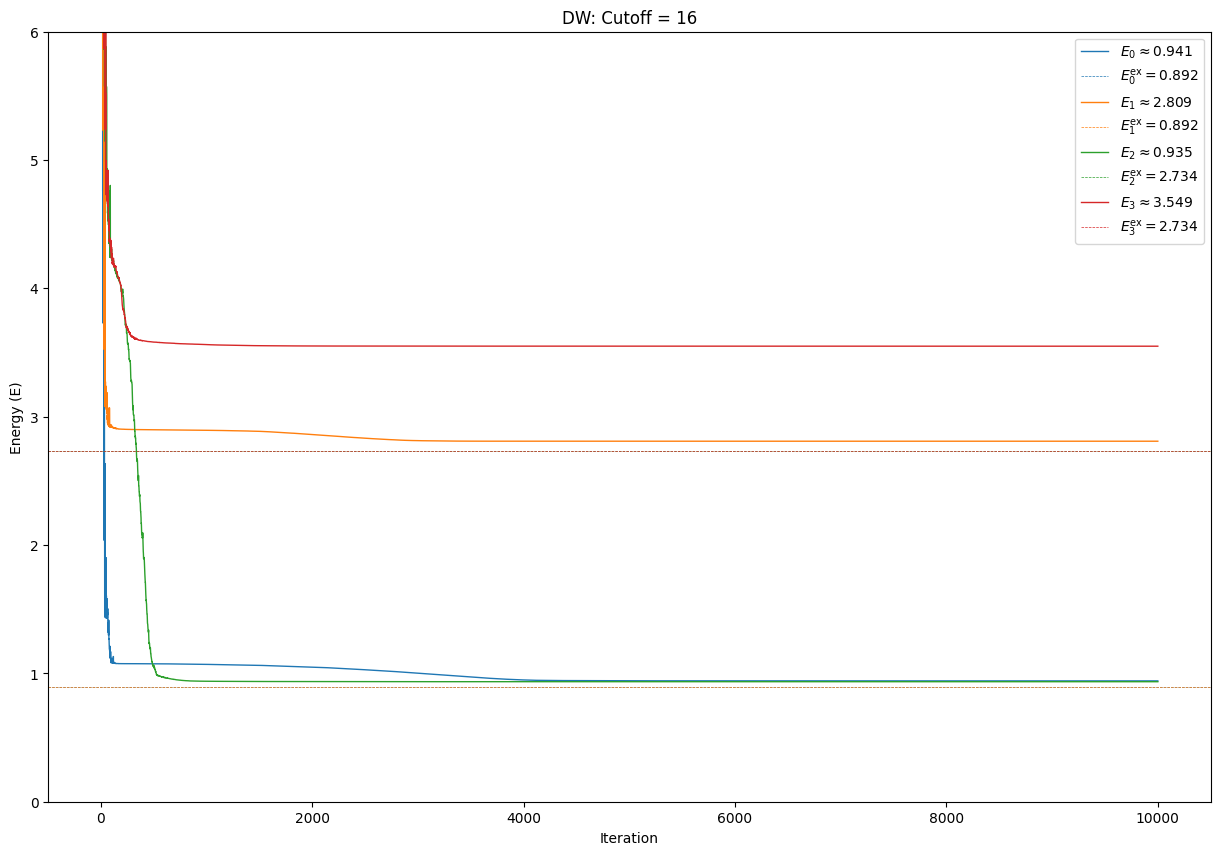

In [49]:
# Plotting each line for different states
plt.figure(figsize=(15, 10))  # Set figure size similar to the uploaded image

for i in range(data['num_VQD']):
    line, = plt.plot(data['num_iters'][i], data['energies'][i], linewidth=1.0, label=f"$E_{{{i}}} \\approx {data['converged_energies'][i]:.3f}$")
    plt.axhline(data['exact_eigenvalues'][i], color = line.get_color(), linestyle='--', linewidth=0.5, label=f"$E_{{{i}}}^{{\\text{{ex}}}} = {data['exact_eigenvalues'][i]:.3f}$")

# Set axis labels and title
plt.xlabel("Iteration")
plt.ylabel("Energy (E)")
plt.title("Energy Convergence for Each Computed State")
plt.title(f"{potential}: Cutoff = {data['cutoff']}")

plt.ylim(0, 6)

plt.legend(loc="upper right")

# Show plot
#plt.show()
plt.savefig(base_path + 'VQD-{}-{}.png'.format(potential,cut_off))
